# Predict College Admission Rates based on the accepted Test Scores

## Preprocessing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.display.max_seq_items = 2000
sns.set_style('darkgrid')

In [2]:
ipeds_2010 = pd.read_csv('data/IPEDS_2010.csv')
ipeds_2011 = pd.read_csv('data/IPEDS_2011.csv')
ipeds_2012 = pd.read_csv('data/IPEDS_2012.csv')
ipeds_2013 = pd.read_csv('data/IPEDS_2013.csv')
ipeds_2014 = pd.read_csv('data/IPEDS_2014.csv')
ipeds_2015 = pd.read_csv('data/IPEDS_2015.csv')
ipeds_2016 = pd.read_csv('data/IPEDS_2016.csv')

Now that the data has been imported, let's do some wrangling... 

First, let's add another column to identify the year of the data record and concat all the read csvs into one dataframe

In [3]:
ipeds_2010['YEAR'] = 2010
ipeds_2011['YEAR'] = 2011
ipeds_2012['YEAR'] = 2012
ipeds_2013['YEAR'] = 2013
ipeds_2014['YEAR'] = 2014
ipeds_2015['YEAR'] = 2015
ipeds_2016['YEAR'] = 2016

In [4]:
data = pd.concat([ipeds_2010, ipeds_2011, ipeds_2012, ipeds_2013,
                  ipeds_2014, ipeds_2015, ipeds_2016])
data.reset_index(drop=True, inplace=True)
data.head()

,ACTCM25,ACTCM75,ACTEN25,ACTEN75,ACTMT25,ACTMT75,ACTNUM,ACTPCT,ACTWR25,ACTWR75,...,XSATMT25,XSATMT75,XSATNUM,XSATPCT,XSATVR25,XSATVR75,XSATWR25,XSATWR75,YEAR,YRSCOLL
0,.,.,.,.,.,.,.,.,.,.,...,A,A,A,A,A,A,A,A,2010,-2.0
1,16,19,15,20,15,18,946,84,.,.,...,R,R,R,R,R,R,R,R,2010,-2.0
2,21,27,21,28,19,26,1494,95,.,.,...,R,R,R,R,R,R,B,B,2010,-2.0
3,.,.,.,.,.,.,.,.,.,.,...,A,A,A,A,A,A,A,A,2010,-2.0
4,22,29,22,30,21,28,575,92,.,.,...,R,R,R,R,R,R,B,B,2010,-2.0


After going through understanding data, I've narrowed it down to 16 important columns which might help us building this model. So let's get those columns from the whole dataset.

In [5]:
required_cols = ['UNITID', 'YEAR', 'ADMCON7',
                'APPLCN', 'ADMSSN', 'ENRLT',
                'ENRLFT', 'ENRLPT', 'SATNUM', 'ACTNUM',
                'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75',
                'ACTCM25', 'ACTCM75']
data = data[required_cols]
data.head()

,UNITID,YEAR,ADMCON7,APPLCN,ADMSSN,ENRLT,ENRLFT,ENRLPT,SATNUM,ACTNUM,SATVR25,SATVR75,SATMT25,SATMT75,ACTCM25,ACTCM75
0,100636,2010,-2,.,.,.,.,.,.,.,.,.,.,.,.,.
1,100654,2010,1,5986,3070,1123,1113,10,152,946,380,470,370,470,16,19
2,100663,2010,1,4667,3847,1571,1542,29,67,1494,490,680,510,690,21,27
3,100690,2010,3,7,5,5,4,1,.,.,.,.,.,.,.,.
4,100706,2010,1,1846,1221,622,600,22,113,575,510,630,510,655,22,29


In [6]:
# shape of data
print("Shape of whole dataset:", data.shape)

Shape of whole dataset: (36739, 16)


The ADMCON7 column is a column which suggests if the school considers SAT/ACT test scores or not. The discrete values for this column are:

| Code | Description |
|:----:|-----------|
| 1 | Required |
| 2 | Recommended |
| 3 | Neither Required nor Recommended |
| 4 | Do not know |
| -1 | Not reported |
| -2 | Not applicable |

Now let's check the distribution of these values in the dataset

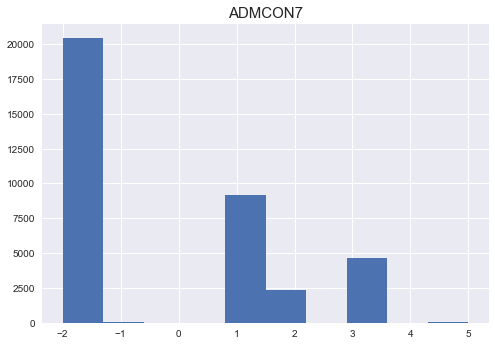

In [7]:
data.ADMCON7.hist()
plt.title('ADMCON7', fontsize=15)
plt.show()

So looks like about 20000 data points are unusable as they are either "Not Applicable" or "Not Reported". Let's get rid of them as they are of no use to us.

In [8]:
data_valid = data[~data.ADMCON7.isin([-1,-2])]
print("Shape of valid data:", data_valid.shape)

Shape of valid data: (16274, 16)


In [9]:
# now let's replace those '.' to NaN for making our lives easier
data_valid = data_valid.replace('.', np.nan)
data_valid.head()

,UNITID,YEAR,ADMCON7,APPLCN,ADMSSN,ENRLT,ENRLFT,ENRLPT,SATNUM,ACTNUM,SATVR25,SATVR75,SATMT25,SATMT75,ACTCM25,ACTCM75
1,100654,2010,1,5986,3070,1123,1113,10,152,946,380,470,370,470,16,19
2,100663,2010,1,4667,3847,1571,1542,29,67,1494,490,680,510,690,21,27
3,100690,2010,3,7,5,5,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100706,2010,1,1846,1221,622,600,22,113,575,510,630,510,655,22,29
5,100724,2010,2,8229,3598,1221,1209,12,255,995,360,440,320,420,13,17


let's also drop rows where all test score columns are null

In [10]:
score_cols = ['SATNUM', 'ACTNUM', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75',
                'ACTCM25', 'ACTCM75']
data_valid.dropna(subset=score_cols, how='all', inplace=True)
data_valid.reset_index(drop=True, inplace=True)
print('Shape of valid data after dropping rows with all NA scores:',data_valid.shape)

Shape of valid data after dropping rows with all NA scores: (9716, 16)


In [11]:
# also, while we're here, let's fix the data type for the columns to be numeric
data_valid = data_valid.apply(pd.to_numeric)

while investigating I stumbled upon a UNITID (100636) which has multiple records for the YEAR 2012, not sure why though. Before making any decisions, I want to see if there are more UNITID-YEAR pairs which share the same behavior

In [12]:
data_valid[(data_valid.UNITID == 100636) & (data_valid.YEAR == 2012)].shape

(1445, 16)

In [13]:
#get a frquency count based on UNITID and YEAR and investigate the ones which have more than one row
df_unitid_year_freq = data_valid.groupby(["UNITID", "YEAR"]).size().reset_index(name='Frequency')
df_unitid_year_freq[df_unitid_year_freq.Frequency > 1.0]

,UNITID,YEAR,Frequency
0,100636,2012,1445


So looks like only one of the UNITID's have multiple records in a year. Maybe something went wrong with the data entry process. Instead of not considering this UNITID at all, I'm thinking of taking an average of all values for it and using them instead, as one complete record.

In [14]:
data_extra = data_valid[(data_valid.UNITID == 100636) & (data_valid.YEAR == 2012)]
data_extra.shape

(1445, 16)

In [15]:
# update data_valid, removing all values which are in data_extra
data_valid = pd.concat([data_valid, data_extra]).drop_duplicates(keep=False)
print('Shape of valid data after removing all rows of repeated UNITID-YEAR:',data_valid.shape)

Shape of valid data after removing all rows of repeated UNITID-YEAR: (8271, 16)


In [16]:
# let's get the mean of all required columns for data_extra
data_extra_dict = dict(data_extra[['APPLCN', 'ADMSSN',
                'ENRLT', 'ENRLFT',
                'ENRLPT', 'SATNUM', 'ACTNUM', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75',
                'ACTCM25', 'ACTCM75']].mean(axis = 0, skipna = True))
data_extra_dict['UNITID'] = 100636
data_extra_dict['YEAR'] = 2012
data_extra_dict['ADMCON7'] = 2
data_extra_mean = pd.DataFrame(data_extra_dict, index=[-1])
data_extra_mean.shape

(1, 16)

In [17]:
# append the calculated mean to the orginally valid dataframe
data_valid = data_valid.append(data_extra_mean, ignore_index=False)
data_valid = data_valid.sort_index().reset_index(drop=True)
data_valid.shape

(8272, 16)

In [18]:
# to verify, let's check how many records the same UNITID and YEAR combination now has
(data_valid[(data_valid.UNITID == 100636) & (data_valid.YEAR == 2012)]).shape

(1, 16)

Looks much better now, so let's start with some more analysis on the data

In [19]:
data_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8272 entries, 0 to 8271
Data columns (total 16 columns):
ACTCM25    7834 non-null float64
ACTCM75    7834 non-null float64
ACTNUM     8267 non-null float64
ADMCON7    8272 non-null int64
ADMSSN     8272 non-null float64
APPLCN     8272 non-null float64
ENRLFT     8272 non-null float64
ENRLPT     7609 non-null float64
ENRLT      8272 non-null float64
SATMT25    7600 non-null float64
SATMT75    7600 non-null float64
SATNUM     8257 non-null float64
SATVR25    7524 non-null float64
SATVR75    7524 non-null float64
UNITID     8272 non-null int64
YEAR       8272 non-null int64
dtypes: float64(13), int64(3)
memory usage: 1.0 MB


So looks like the total number of records in the valid data is 8272 but there are still some columns with `null` values. Rather than dropping these rows and reducing the size of our already small dataset, I am going to fill these `null` values with the mean of the column they are in. Filling with mean will not have a major statistical effect on the overall distribution of the column and so is a safe bet. 

In [20]:
data_valid = data_valid.fillna(data_valid.mean())

Seems much more reasonable now so lets try getting some analysis done.

ADMSSN(number of admissions) and ENRLT(number of enrollment) cannot be 0 for a college, if it is then seems like something wrong with the data for that college or for that year.

SATNUM(number of students reporting SAT scores) and ACTNUM(number of students reporting ACT scores) doesn't makes sense to include the data where this number is 0.

In [21]:
#let's get records where any of these 4 features have 0 values
data_valid[(data_valid['ADMSSN'] == 0) |
           (data_valid['ENRLT'] == 0) |
           (data_valid['SATNUM'] == 0) |
           (data_valid['ACTNUM'] == 0)]

,ACTCM25,ACTCM75,ACTNUM,ADMCON7,ADMSSN,APPLCN,ENRLFT,ENRLPT,ENRLT,SATMT25,SATMT75,SATNUM,SATVR25,SATVR75,UNITID,YEAR
6,18.000000,23.000000,771.0,1,1339.0,1409.0,736.0,135.000000,871.0,476.27967,585.387637,0.0,468.986109,578.527387,100830,2010
13,18.000000,24.000000,357.0,1,391.0,965.0,325.0,32.000000,357.0,476.27967,585.387637,0.0,468.986109,578.527387,101587,2010
20,19.000000,24.000000,1575.0,1,3777.0,4369.0,1707.0,65.000000,1772.0,476.27967,585.387637,0.0,468.986109,578.527387,102094,2010
24,18.000000,23.000000,1323.0,1,4336.0,6238.0,1997.0,1326.000000,3323.0,476.27967,585.387637,0.0,468.986109,578.527387,102368,2010
33,17.000000,25.000000,701.0,1,1851.0,2120.0,674.0,27.000000,701.0,476.27967,585.387637,0.0,468.986109,578.527387,106245,2010
39,19.000000,22.000000,49.0,1,65.0,94.0,49.0,0.000000,49.0,476.27967,585.387637,0.0,468.986109,578.527387,106546,2010
40,20.000000,27.000000,1696.0,1,3595.0,3821.0,1753.0,24.000000,1777.0,476.27967,585.387637,0.0,468.986109,578.527387,106704,2010
45,22.000000,23.000000,45.0,1,45.0,66.0,45.0,0.000000,45.0,476.27967,585.387637,0.0,468.986109,578.527387,107123,2010
50,19.000000,24.000000,159.0,1,348.0,521.0,159.0,0.000000,159.0,476.27967,585.387637,0.0,468.986109,578.527387,107877,2010
86,20.366779,25.459069,0.0,1,0.0,1.0,0.0,0.000000,0.0,476.27967,585.387637,0.0,468.986109,578.527387,112312,2010


After going through these there was one thing which was going on in my mind - some records have SATNUM as 0 but have a value for ACTNUM and vice-versa. This looked interesting, so I thought of doing some more research and looking back into the data dictionary. After some digging and wrapping my head around the complicated way the variables are define, I figured out that its not necessary for a college to report both these numbers if they don't consider either one of them, which means -

If a college only considers ACT scores for admission, then the SATNUM will be reported as 0 for that college and vice-versa


This made me think, that I should be working on developing separate models for this, but then looking at the counts on the data above (only 841 records), which is very small to even start building a model on, I think a better idea would be to only consider colleges which have values reported for both these columns, i.e., only colleges which accept students with both SAT and ACT test scores. So, let's drop these ~850 records from our data_valid.

In [22]:
print("Shape of data before dropping records with 0 values for SATNUM/ACTNUM:", data_valid.shape)

data_valid = data_valid[~((data_valid['SATNUM'] == 0) | (data_valid['ACTNUM'] == 0))]

print("Shape of data after dropping records with 0 values for SATNUM/ACTNUM:", data_valid.shape)

Shape of data before dropping records with 0 values for SATNUM/ACTNUM: (8272, 16)
Shape of data after dropping records with 0 values for SATNUM/ACTNUM: (7431, 16)


In [23]:
#check for ADMSSN and ENRLT values as 0
(data_valid[(data_valid['ADMSSN'] == 0) | (data_valid['ENRLT'] == 0)]).shape

(0, 16)

Great, so looks like removing those 0 SATNUM/ACTNUM records also fixed the issue with ADMSSN/ENRLT being 0 (there were 5 records of those)

As we are using the composite scores for ACT, which is basically a mean of all the 4 ACT test sections (English, Math, Reading, and Science), let's also compute the composite score for SAT sections.


*** P.S. We are not cosidering the Writing section for both SAT and ACT ***

In [24]:
data_valid['SATCM25'] = np.round((data_valid['SATVR25'] + data_valid['SATMT25'])/2)
data_valid['SATCM75'] = np.round((data_valid['SATVR75'] + data_valid['SATMT75'])/2)
data_valid.head()

,ACTCM25,ACTCM75,ACTNUM,ADMCON7,ADMSSN,APPLCN,ENRLFT,ENRLPT,ENRLT,SATMT25,SATMT75,SATNUM,SATVR25,SATVR75,UNITID,YEAR,SATCM25,SATCM75
0,20.349515,25.345034,513.875433,2,3197.444291,5781.0609,966.028374,24.847751,990.876125,477.493958,587.04003,556.849827,468.482811,579.061115,100636,2012,473.0,583.0
1,16.000000,19.000000,946.000000,1,3070.000000,5986.0000,1113.000000,10.000000,1123.000000,370.000000,470.00000,152.000000,380.000000,470.000000,100654,2010,375.0,470.0
2,21.000000,27.000000,1494.000000,1,3847.000000,4667.0000,1542.000000,29.000000,1571.000000,510.000000,690.00000,67.000000,490.000000,680.000000,100663,2010,500.0,685.0
3,22.000000,29.000000,575.000000,1,1221.000000,1846.0000,600.000000,22.000000,622.000000,510.000000,655.00000,113.000000,510.000000,630.000000,100706,2010,510.0,642.0
4,13.000000,17.000000,995.000000,2,3598.000000,8229.0000,1209.000000,12.000000,1221.000000,320.000000,420.00000,255.000000,360.000000,440.000000,100724,2010,340.0,430.0


Now that we have these columns, let's drop the old SAT columns

In [25]:
data_valid = data_valid.drop(['SATMT25','SATMT75','SATVR25','SATVR75'], axis = 1)
data_valid.describe()

,ACTCM25,ACTCM75,ACTNUM,ADMCON7,ADMSSN,APPLCN,ENRLFT,ENRLPT,ENRLT,SATNUM,UNITID,YEAR,SATCM25,SATCM75
count,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000,7431.000000
mean,20.462108,25.574365,565.297832,1.079935,3469.311458,6322.096496,1006.494150,25.356279,1029.583754,572.673220,187319.775939,2013.142511,473.152200,582.834073
std,3.584460,3.440433,890.219054,0.433850,4480.923629,9357.869433,1302.621702,83.649375,1333.421717,908.221063,56191.411519,2.111243,69.831513,69.517189
min,6.000000,9.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,3.000000,1.000000,100636.000000,2010.000000,250.000000,320.000000
25%,18.000000,23.000000,107.000000,1.000000,833.000000,1263.000000,256.000000,1.000000,262.000000,61.000000,152266.000000,2011.000000,429.000000,535.000000
50%,20.000000,25.000000,244.000000,1.000000,1839.000000,2965.000000,489.000000,4.000000,499.000000,239.000000,185828.000000,2013.000000,460.000000,575.000000
75%,22.000000,28.000000,576.000000,1.000000,4023.000000,6810.000000,1171.500000,26.609258,1203.000000,638.500000,215309.000000,2015.000000,505.000000,620.000000
max,34.000000,36.000000,6865.000000,5.000000,36088.000000,97112.000000,9488.000000,2000.000000,10835.000000,8795.000000,489937.000000,2016.000000,755.000000,800.000000


Starting to look better. One last step before modeling - normalization. Given that we are using 2 scores (ACT and SAT), which have a very distinct score range - ACT max for a section is 36 and SAT max for a section is 800, so lets normalize them.

In [26]:
data_valid['ACTCM25_NORM'] = data_valid['ACTCM25'].map(lambda x: x/36)
data_valid['ACTCM75_NORM'] = data_valid['ACTCM75'].map(lambda x: x/36)

data_valid['SATCM25_NORM'] = data_valid['SATCM25'].map(lambda x: x/800)
data_valid['SATCM75_NORM'] = data_valid['SATCM75'].map(lambda x: x/800)

data_valid.head()

,ACTCM25,ACTCM75,ACTNUM,ADMCON7,ADMSSN,APPLCN,ENRLFT,ENRLPT,ENRLT,SATNUM,UNITID,YEAR,SATCM25,SATCM75,ACTCM25_NORM,ACTCM75_NORM,SATCM25_NORM,SATCM75_NORM
0,20.349515,25.345034,513.875433,2,3197.444291,5781.0609,966.028374,24.847751,990.876125,556.849827,100636,2012,473.0,583.0,0.565264,0.704029,0.59125,0.72875
1,16.000000,19.000000,946.000000,1,3070.000000,5986.0000,1113.000000,10.000000,1123.000000,152.000000,100654,2010,375.0,470.0,0.444444,0.527778,0.46875,0.58750
2,21.000000,27.000000,1494.000000,1,3847.000000,4667.0000,1542.000000,29.000000,1571.000000,67.000000,100663,2010,500.0,685.0,0.583333,0.750000,0.62500,0.85625
3,22.000000,29.000000,575.000000,1,1221.000000,1846.0000,600.000000,22.000000,622.000000,113.000000,100706,2010,510.0,642.0,0.611111,0.805556,0.63750,0.80250
4,13.000000,17.000000,995.000000,2,3598.000000,8229.0000,1209.000000,12.000000,1221.000000,255.000000,100724,2010,340.0,430.0,0.361111,0.472222,0.42500,0.53750


As a last step before modeling (I promise this is definitely the last one), let's check the correlation between the scores and admissions

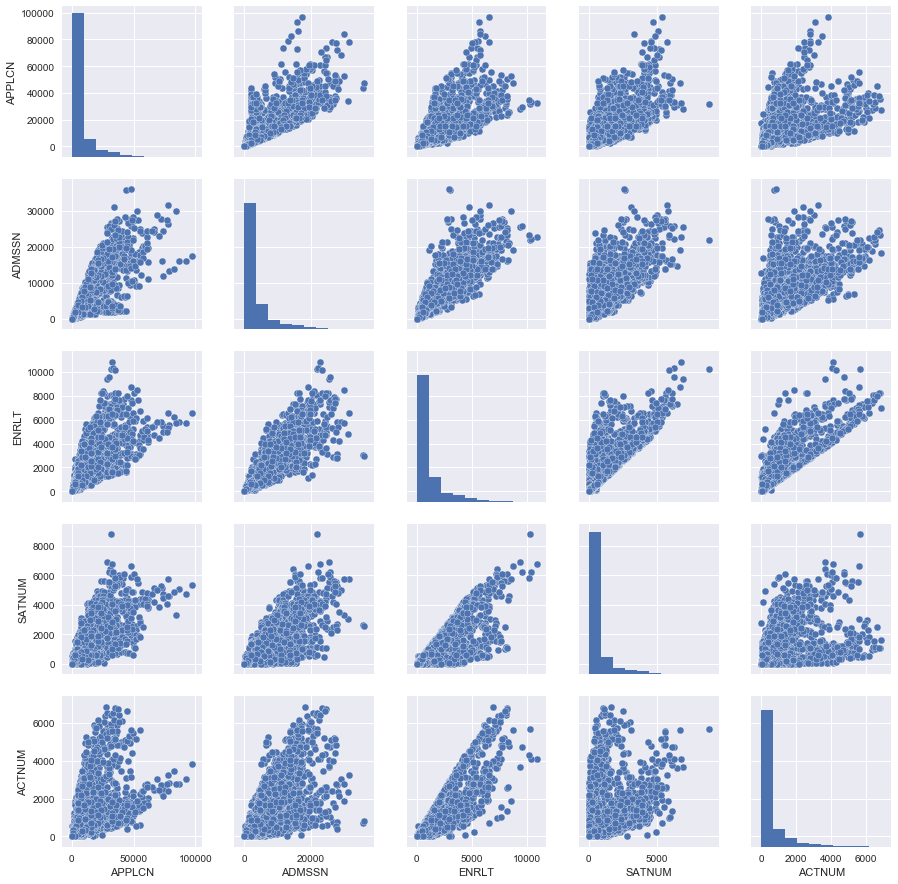

In [27]:
# pairplot for correlation of important features
sns.pairplot(data_valid[['APPLCN','ADMSSN','ENRLT','SATNUM','ACTNUM']])
plt.show()

So that looks good - basically the number of applicants submitting their SAT/ACT scores have a direct correlation with the rate of Admissions. 

There maybe some colleges with low Admission rates even if the scores are provided but that can depend on a lot of other factors like college's location (some colleges in small towns may not be as popular as others in bigger cities), or courses provided (if a college is giving many course options, it may be favored over others those are not).

## Begin Modeling

### Baseline using a Linear Model

Enough of pre-processing, let's put our data into a LinearRegression model and see how it performs.

In [28]:
# let's get our labels (ADMSSN) separated
labels_ADMSSN = data_valid['ADMSSN']
data_modeling = data_valid[['APPLCN','SATNUM','ACTNUM','YEAR', 
                            'ACTCM25_NORM', 'ACTCM75_NORM', 'SATCM25_NORM', 'SATCM75_NORM']]

#let's also divide our modeling data in train-test splits for ADMSSN labels
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_modeling, 
                                                    labels_ADMSSN, 
                                                    test_size = 0.20, 
                                                    random_state = 11)

In [29]:
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
#train the model
linreg_model.fit(x_train, y_train)

# let's test our trained model on the test set
linreg_model.score(x_test, y_test)

0.81934105563357129

Woah! That's a really good baseline model. Our basic LinearRegression model gave an r^2 value of about **.82** (scikit-learn's implementation of LinearRegression automatically returns the r^2 value when the score() is called), which is great. In the next steps, let's try to improve our model by using few other more sophisticated algorithms like RandomForest, GradientBoosting and Neural Nets (Deep Learning)

#### Reference

[Scikit-Learn LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

### Create a function for plotting the Learning Curve

In [45]:
from sklearn.model_selection import GridSearchCV, learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    # Code Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title, fontsize=12)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Using RandomForest

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Set the best parameters by cross-validation
test_params = {'n_estimators': [100, 500, 1000], 'max_depth': [2, 3, 4, 6], 'random_state': [10]}

rf_model = GridSearchCV(estimator = RandomForestRegressor(),
                        param_grid = test_params,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1)

rf_model.fit(x_train,y_train)
rf_model.score(x_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


0.92600137798882287

In [38]:
print ("Best Random Forest Regressionr estimator from GridSearch:")
print (rf_model.best_estimator_)

Best Random Forest Regressionr estimator from GridSearch:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=10,
           verbose=0, warm_start=False)


That's a nice improvement over our Baseline model's performance. We got to about **.93** r^2 value with a RandomForestRegressor model using 1000 estimators(decision trees) with a max depth of each tree as 6.

#### Reference

[Scikit-Learn RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

### Using GradientBoosting

GradientBoosting has recently gained a lot of popularity in the Machine Learning industry. It is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. How about we put it to test ourselves.

#### Reference

[Intro to GradientBoosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

[Using GradientBoosting for Predicting House Prices](https://towardsdatascience.com/create-a-model-to-predict-house-prices-using-python-d34fe8fad88f)

[Scikit-Learn GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GridSearchCV(estimator = GradientBoostingRegressor(),
                        param_grid = test_params,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1)
gb_model.fit(x_train, y_train)
gb_model.score(x_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.7s finished


0.9476309878628596

In [41]:
print ("Best Gradient Boosting Regression estimator from GridSearch:")
print (gb_model.best_estimator_)

Best Gradient Boosting Regression estimator from GridSearch:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=10, subsample=1.0, verbose=0,
             warm_start=False)


Look at that! Using GradientBoosting, which uses the average prediction of multiple weak-learners to give a better learned model, we improved our model quite a lot from our initial baseline. We now get an r^2 value of **0.95** with a GradientBoostingRegressor model using 500 estimators(decision trees) with a max depth of each learner as 6 and a default learning rate of 0.1

### Using Deep Learning 

So far we have played around with some very sophisticated decision tree based algos like RandomForest and GradientBoosting. How about we try using Deep Neural Networks to predict the rate of admissions?

We will use Keras for building our Deep Neural Network

- Define a Sequential Model
- Add few Dense Layers
- Use `relu` as the activation function for the hidden layers
- Use `RandomNormal` as the initializer for the kernel (Initializers define the way to set initial randome weights for the layers)
- Use `mean absolute error` as the loss function
- Have one-node output layer
- Use `Linear` as activation function for the output layer
- Use custom function for computing r^2 metrics


#### Reference

[Deep Neural Nets for Regression](https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33)

[Custom Metric Function for Keras](https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/)

In [46]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [47]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [48]:
dl_model = Sequential()
# The Input Layer :
dl_model.add(Dense(32, kernel_initializer='RandomNormal', input_dim = x_train.shape[1], activation='relu'))

# The Hidden Layers :
dl_model.add(Dense(64, kernel_initializer='RandomNormal',activation='relu'))
dl_model.add(Dense(64, kernel_initializer='RandomNormal',activation='relu'))

# The Output Layer :
dl_model.add(Dense(1, kernel_initializer='RandomNormal',activation='linear'))

# Compile the network :
dl_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[coeff_determination])
dl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 6,625.0
Trainable params: 6,625
Non-trainable params: 0.0
_________________________________________________________________


In [49]:
checkpoint_name = 'dl_weights/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [50]:
dl_model.fit(x_train.as_matrix(), y_train.as_matrix(), epochs=50, batch_size=16, validation_split = 0.2, callbacks=callbacks_list)

Train on 4755 samples, validate on 1189 samples
Epoch 1/50
4755/4755 [==============================] - 0s - loss: 1261.8417 - coeff_determination: 0.3857 - val_loss: 872.2755 - val_coeff_determination: 0.7326
Epoch 2/50
4755/4755 [==============================] - 0s - loss: 849.8495 - coeff_determination: 0.6773 - val_loss: 852.2873 - val_coeff_determination: 0.7064
Epoch 3/50
4755/4755 [==============================] - 0s - loss: 820.4636 - coeff_determination: 0.7401 - val_loss: 796.9061 - val_coeff_determination: 0.8022
Epoch 4/50
4755/4755 [==============================] - 0s - loss: 789.0401 - coeff_determination: 0.7717 - val_loss: 777.5897 - val_coeff_determination: 0.8068
Epoch 5/50
4755/4755 [==============================] - 0s - loss: 777.5987 - coeff_determination: 0.7964 - val_loss: 774.2847 - val_coeff_determination: 0.7916
Epoch 6/50
4755/4755 [==============================] - 0s - loss: 766.3537 - coeff_determination: 0.7895 - val_loss: 854.8835 - val_coeff_determi

In [51]:
# Load weights file of the best model :
weights_file = 'dl_weights/Weights-048--704.18595.hdf5' # choose the best checkpoint 
dl_model.load_weights(weights_file) # load it
dl_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[coeff_determination])

In [52]:
dl_predicted_test = dl_model.predict(x_test.as_matrix())
from sklearn.metrics import r2_score

r2_score(y_test, dl_predicted_test.flatten())

0.8344122801676247

So seems like our Deep Neural Network performs a bit better than our baseline model (r^2 of **0.84** as compared to 0.82) but not as good as the other tree-based models. This was kind of expected given such a less amount of training data for the Deep Learning (Neural Nets) to learn from. Their benefit is significantly visible with huge quantities of data.

### Conclusion

As we can see the best r^2 value was given by GradientBoostingRegressor, so we can use it as our final model for predicting admission rates for any other colleges based on their test scores.

Let's also check the learning curve of our selected model to check how well the model is learning from the data

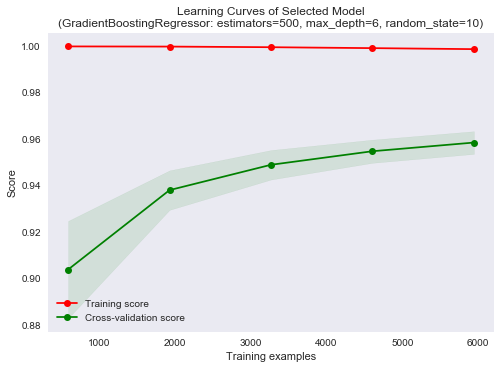

In [54]:
from sklearn.model_selection import ShuffleSplit
plot_title = "Learning Curves of Selected Model\n(GradientBoostingRegressor: estimators=500, max_depth=6, random_state=10)"

# GBR is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(estimator = gb_model.best_estimator_, 
                    title = plot_title, 
                    X = data_modeling, 
                    y = labels_ADMSSN, 
                    cv = cv, 
                    n_jobs = -1)

plt.show()